In [2]:
from pathlib import Path

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, ConcatDataset
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

最初に、非常に長いので、IPython-notebook-extensionを導入し、Table of Contentsを有効化することをおすすめします。<br>
詳しくは、<br>
https://cartman0.hatenablog.com/entry/2016/03/28/170319
<br>などを参考にしてください。

## pytorchの主なパッケージ
torch<br>
torch.nn<br>
torch.optim<br>
torch.autograd<br>
torch.utils<br>
torch.multiprocessing<br>
torchvision<br>

## テンソル
### テンソルとは
pytorchではTensorという型で演算を行います。<br>
Tensorはその名の通りテンソル、つまり多次元配列を扱うためのデータ構造です。<br>
NumPyのndarrayとほぼ同様のAPIを有しており、それに加えてGPUによる計算もサポートしています。<br>
Tensorは各データ型に対して定義されており、例えば32bitの浮動小数点数でしたらtorch.FloatTensorを、64bitの符号付き整数でしたらtorch.LongTensorを使用します。<br>

また、GPU上で計算する場合はtorch.cuda.FloatTensorなどを使用します。なお、TensorはFloatTensorのエイリアスです。いずれの型のTensorでもtorch.tensorという関数で作成することができます。

In [3]:
t1 = torch.tensor([[1,2,3],[4,5,6]])
#引数のリストの値で初期化したテンソルを作成します.
t2 = torch.empty(5, 3)
t3 = torch.rand(5, 3)
t4 = torch.zeros(5, 3, dtype=torch.long)
t5 = torch.FloatTensor(2,3,4)
#(2 x 3 x 4)のテンソルで初期化されていないものを作成しています。pytorchでは最初の２がチャネル数を意味するので注意してください。
t6 = torch.randn(3,4,5)
#(3 x 4 x 5)のテンソルで平均０分散１の正規分布で初期化したものを作成しています

### インプレース/アウトオブプレース
最後に_をつけると、元の変数の内容が変わります.

In [3]:
t = torch.tensor([[1,2,3],[4,5,6]])
t.fill_(3.5)
print(t)
t.add(3.5)
print(t)
t.add_(3.5)
print(t)

tensor([[3, 3, 3],
        [3, 3, 3]])
tensor([[3, 3, 3],
        [3, 3, 3]])
tensor([[6, 6, 6],
        [6, 6, 6]])


### インデキシング
以下のようにnumpyと同様のインデキシング操作をサポートしています.

In [7]:
t = torch.tensor([[1,2,3], [4,5,6.]])

# スカラーの添字で指定
t[0, 2]

# スライスで指定
t[:, :2]

# 添字のリストで指定
t[:, [1,2]]

# マスク配列を使用して3より大きい部分のみ選択
t[t > 3]

# [0, 1]要素を100にする
t[0, 1] = 100

# スライスを使用した一括代入
t[:, 1] = 200

# マスク配列を使用して特定条件の要素のみ置換
t[t > 10] = 20

### テンソルの演算
四則演算はTensor同士かTensorとPythonのスカラーの数値との間でのみ可能です。<br>
Tensorとndarrayとでは演算がサポートされていないことに注意してください。

　また、Tensor同士の場合も同じ型である必要があります。<br>
 例えばFloatTensorとDoubleTensorの演算はエラーになります。<br>
 四則演算はndarrayと同様にブロードキャストが適用され、ベクトルとスカラーや行列とベクトル間の演算でも自動的に次元が補間されます。

In [5]:
# 長さ3のベクトル
v = torch.tensor([1, 2, 3.])
w = torch.tensor([0, 10, 20.])
# 2 × 3の行列
m = torch.tensor([[0, 1, 2], [100, 200, 300.]])

# ベクトルとスカラーの足し算
v2 = v + 10
# 累乗も同様
v2 = v ** 2
# 同じ長さのベクトル同士の引き算
z = v - w
# 複数の組み合わせ
u = 2 * v - w / 10 + 6.0

# 行列とスカラー
m2 = m * 2.0
# 行列とベクトル
#(2, 3)の行列と(3,)のベクトルなのでブロードキャストが働く
m3 = m + v
# 行列同士
m4 = m + m

### 数学関数
演算子<br>
・dot :ベクトルの内積<br>
・mv :行列とベクトルの積<br>
・mm :行列と行列の積<br>
・matmal :引数の種類によって自動的にdot,mv,mmを選択して実行<br>
・gsev :LU分解による連立方程式の解<br>
・eig,symeig :固有値分解. symeigは対称行列用のより効率のよいアルゴリズム<br>
・svd :特異値分解<br>

その他の関数

In [6]:
# 100 × 10のテストデータを用意
X = torch.randn(100, 10)

# 数学関数を含めた数式
y = X * 2 + torch.abs(X)

# 平均値を求める
m = torch.mean(X)
# 関数ではなく、メソッドとしても利用できる
m = X.mean()
# 集計結果は0次元のTensorでitemメソッドを使用して、
# 値を取り出すことができる
m_value = m.item()
# 集計は次元を指定できる。以下は行方向に、
# 集計して列ごとに平均値を計算している
m2 = X.mean(0)

### インデキシング操作関数

In [7]:
x1 = torch.tensor([[1, 2], [3, 4.]]) # 2×2
x2 = torch.tensor([[10, 20, 30], [40, 50, 60.]]) # 2×3

# 2×2を4×1に見せる
x1.view(4, 1)
# -1は残りの次元を表し、一度だけ使用できる
# 以下の例では-1とすると自動的に4になる
x1.view(1, -1)

# 2×3を転置して3×2にする
x2.t()

# dim=1に対して結合することで2×5のTensorを作る
torch.cat([x1, x2], dim=1)

# 画像データの形式をHWC(縦、横、色)をCHWCHW(色、縦、横)に変換
# 64×32×3のデータが100個
hwc_img_data = torch.rand(100, 64, 32, 3)
chw_img_data = hwc_img_data.transpose(1, 2).transpose(1, 3)

### GPU の使用

In [113]:
import torch

x = torch.randn(10)
y = torch.randn(10)
#Pytorch 0.4 以降
x = x.to('cuda')
y = y.to('cuda:0') # cudaの後に:数字で対応したGPUを使用

z = x * y

z = z.to('cpu') # cpuへ
print(x.is_cuda) # 変数がGPU上にあればTrue

AssertionError: Torch not compiled with CUDA enabled

### tensorとnumpyの相互変換
Tensor -> numpy ： (Tensorの変数).numpy()<br>
numpy -> Tensor ： torch.from_numpy(Numpyの変数)<br>
ただし、GPU上のTensorはそのままでは変換できず、一度CPU上に移す必要があります

In [8]:
# numpyメソッドを使用してndarrayに変換
t = torch.tensor([[1, 2], [3, 4.]])
x = t.numpy()

# GPU上のTensorはcpuメソッドで、
# 一度CPUのTensorに変換する必要がある
t = torch.tensor([[1, 2], [3, 4.]], device="cuda:0")
x = t.to("cpu").numpy()

AssertionError: Torch not compiled with CUDA enabled

## データの取得
pytorchで与えるデータはTensor(train), Tensor(target)のようにする必要がある。<br>
データラベルを同時に変換させる関数としてTensorDatasetがある。pytorchのDataLoaderはバッチ処理のみ対応している。
### transforms/Dataset/DataLoader
学習時のデータの前処理および、データの(バッチ毎の)ロードを行うためにtransforms/Dataset/DataLoaderが用意されている。大まかな役割としては、<br>
・transform : データの前処理を担当するモジュール<br>
・Dataset : データとそれに対応するラベルを1組返すモジュール。データを返すときにtransformを使って前処理を行う。<br>
・DataLoader : データセットからデータをバッチサイズに固めて返すモジュール<br>
となっている。以下で順に例を用いて説明する。
#### transforms
transformsはデータの前処理を行う部分であり、CropやFlipなどの画像処理においてよく用いられるものは、torchvision.transformsに入っているが、これを自分で好きなように実装することもできる。<br>
ただし、自分で実装する際には、__call__を実装した、「コール可能なクラス」として実装する必要がある。<br>
※ 因みに、__init__はインスタンス生成時に実行し、一度生成したインスタンスを引数を与え関数のように呼び出せば__init__と同時に__call__が実行される。<br>
callを用いたクラスとして実装することで、インスタンス化時に前処理に使うパラメータを全部渡しておけるので、前処理を実行するたびにパラメータを渡す手間が省ける、ということで「コール可能なクラス」を推奨している(らしい)

In [143]:
class Square(object):
    def __init__(self):
        pass
    def __call__(self,sample):
        return sample**2

#### Dataset
Datasetは入力データとそれに対応するラベルを1組返すモジュール。<br>
PyTorchでは有名なデータセットがあらかじめtorchvision.datasetsに定義されている。(MNIST/CIFAR/STL10など)<br>
扱うデータが画像でクラスごとにフォルダ分けされている場合はtorchvision.datasets.ImageFolderという便利なクラスもある。(KerasのImageDataGeneratorのflow_from_directory()のような機能)<br>

Datasetを実装するのに必要な要件<br>
オリジナルDatasetを実装するときに守る必要がある要件は以下３つ。<br>
・torch.utils.data.Datasetを継承する。<br>
・__len__を実装する。<br>
・__getitem__を実装する。<br>
__len__は、len(obj)で実行されたときにコールされる関数。<br>
__getitem__は、obj[i]のようにインデックスで指定されたときにコールされる関数。<br>
今回は、データは数字のリスト、ラベルは偶数の場合だけTrueになるものを出力するDatasetを実装する。<br>

In [146]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, data_num, transform=None):
        self.transform = transform
        self.data_num = data_num
        self.data = []
        self.label = []
        for x in range(self.data_num):
            self.data.append(x) # 0 から (data_num-1) までのリスト
            self.label.append(x%2 == 0) # 偶数ならTrue 奇数ならFalse

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label =  self.label[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

#### DataLoader
データセットからデータをバッチサイズに固めて返すモジュール<br>
DataLoaderはデータセットを使ってバッチサイズ分のデータを生成する。<br>
またデータのシャッフル機能も持つ。<br>
データを返すときは、データをtensor型に変換して返す。<br>
DataLoaderは、torch.utils.data.DataLoaderというクラスが既に用意されている。たいていの場合、このクラスで十分対応できるので、今回はこのクラスにこれまで実装してきたDatasetを渡して動作を見てみる。

In [168]:
data_set = MyDataset(20, transform=Square())
dataloader = torch.utils.data.DataLoader(data_set, batch_size=4, shuffle=True)

for i in dataloader:
    print(i)

[tensor([100, 121,  49,  81]), tensor([1, 0, 0, 0])]
[tensor([169, 196,  36,   1]), tensor([0, 1, 1, 0])]
[tensor([ 64,   4, 256,   9]), tensor([1, 1, 1, 0])]
[tensor([324, 289, 144, 225]), tensor([1, 0, 1, 0])]
[tensor([361,  16,   0,  25]), tensor([0, 1, 1, 0])]


### CIFARのロードとDataLoader
CIFARなどのデータセットはtorchvisionに実装されている

In [79]:
#train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transforms.ToTensor(),
                                             download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# Fetch one data pair (read data from disk).
image, label = train_dataset[0]
print (image.size())
print (label)

# Data loader (this provides queues and threads in a very simple way).
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
# When iteration starts, queue and thread start to load data from files.
data_iter = iter(train_loader)

# Mini-batch images and labels.
images, labels = data_iter.next()

# Actual usage of the data loader is as below.
for images, labels in train_loader:
    # Training code should be written here.
    pass

Files already downloaded and verified
torch.Size([3, 32, 32])
6


shuffle=Trueなどとすることであらかじめシャッフルしておくことも可能<br><br>
また、torchvisionを使って画像処理関連処理(transformでTensor化、標準化、クロップなどの処理を一律に実行可能)、<br>
CIFAR-10などのデータセットの読み込みができる

In [80]:
#画像の変形処理
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#CIFAR-10のTensorに変形前のtrainsetのロード
rawtrainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

#CIFAR-10のtrain, testsetのロード
#変形はtransformを適用
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

#DataLoaderの適用->これによりバッチの割り当て・シャッフルをまとめて行うことができる
#batch_sizeでバッチサイズを指定
#num_workersでいくつのコアでデータをロードするか指定(デフォルトはメインのみ)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


0it [00:00, ?it/s]


 61%|██████    | 104284160/170498071 [00:28<00:12, 5412581.52it/s]


100%|█████████▉| 170024960/170498071 [00:40<00:00, 5383276.47it/s]

Files already downloaded and verified
Files already downloaded and verified



170500096it [00:55, 5383276.47it/s]                               

### mnistのロード

In [161]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=12, shuffle=True)#, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=12, shuffle=True)#, **kwargs)

## Autograd(自動微分)

Tensorには**requires_grad**という属性があり、これをTrueにすることで自動微分を行うフラグが有効になります。<br>
ニューラルネットワークを扱う場合、パラメータやデータはすべてこのフラグが有効になっています。<br>
PyTorch 0.3以前は自動微分を使用するためにはVariableというクラスでTensorをラップする必要がありましたが、0.4からはTensorとVariableが統合されました。<br>
requires_gradが有効なTensorに対して様々な演算を積み重ねていくことで計算グラフが構築され、backwardメソッドを呼ぶと、その情報から自動的に微分を計算することができます。以下では、
$$y_i=ax_i\\
L=\Sigma_iy_i$$
で計算されるLを$a_k$についてについて微分をしてみます。<br>
このシンプルな例では解析的に解けて、
$$\frac{\partial L}{\partial a_k}=\Sigma_ix_{ik}$$
となりますが、これを自動微分で求めてみます

In [40]:
x = torch.tensor([[1,2,3.],[4,5,6.],[7,8,9.]],requires_grad=True)
# 微分の変数として扱う場合はrequires_gradフラグをTrueにする
a = torch.tensor([1, 2, 3.], requires_grad=True)

# 計算をすることで自動的に計算グラフが構築されていく
y = torch.mv(x, a)#行列xとベクトルyの内積です.
L = y.sum()
print("grad_fn ",y.grad_fn)

# 微分を実行する
L.backward()
print("aで微分\n",a.grad) #xaという演算はaというベクトルにaの各行をかけたものの和となるので、勾配はxの各行の和のベクトルとなる。
# 解析解と比較. tensorではbooleanは0,1で表現されるらしい.
print(a.grad == x.sum(0))
a.detach()
print("xで微分\n",x.grad) #1,2,3というベクトルがaの3つのベクトルにかけられていると解釈できる。

grad_fn  <MvBackward object at 0x119937908>
aで微分
 tensor([12., 15., 18.])
tensor([1, 1, 1], dtype=torch.uint8)
xで微分
 tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]])


### 関数を用いた演算の勾配

In [139]:
x = torch.randn(10,3)
y = torch.randn(10,2)
linear = nn.Linear(3,2)

# Build loss function and optimizer.
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(linear.parameters(),lr=0.01)
pred = linear(x)
loss = criterion(pred,y)
print("最初のloss : ",loss)
loss.backward()
optimizer.step()
# You can also perform gradient descent at the low level.
# linear.weight.data.sub_(0.01 * linear.weight.grad.data)
# linear.bias.data.sub_(0.01 * linear.bias.grad.data)
pred= linear(x)
print("一回学習後  : ",loss)

#以下、もっと学習してみる・・・(ただし、データがランダムなのでそんなにロスは落ちません)
for i in range(1000):
    loss = criterion(pred,y)
    loss.backward()
    optimizer.step()
    pred= linear(x)
loss = criterion(pred,y)
print("沢山学習後  : ",loss)

最初のloss :  tensor(2.0317, grad_fn=<MseLossBackward>)
一回学習後  :  tensor(2.0317, grad_fn=<MseLossBackward>)
沢山学習後  :  tensor(1.7883, grad_fn=<MseLossBackward>)


## 線型回帰モデル
### 直感的な実装

In [47]:
#真の分布
w_true = torch.Tensor([1,2,3])

#Xのデータの準備。切片を回帰係数に含めるため、Xの最初の次元に1を追加しておく。
X = torch.cat([torch.ones(100,1), torch.randn(100,2)], 1)
#真の係数と各Xとの内積を行列とベクトルの積でまとめて計算
y = torch.mv(X,w_true) + torch.randn(100)*0.5

#勾配降下で最適化するためのパラメータのTensorを乱数で初期化して作成
w = torch.randn(3, requires_grad = True)

#学習率
gamma = 0.1

In [48]:
#損失関数のログ
losses = []

#100回イテレーションを回す
for epoc in range(100):
    #前回のepochのbackwardメソッドで計算された勾配の値を削除
    w.grad = None
    
    #線型モデルでyの予測値を計算
    y_pred = torch.mv(X, w)
    
    #MSE lossとwによる微分を計算
    loss = torch.mean((y - y_pred)**2)
    loss.backward()
    
    #勾配を更新する
    #wをそのまま代入して更新すると異なるTensorになって計算グラフが破壊されてしまうのでdataだけを更新する。
    w.data = w.data - gamma * w.grad.data
    
    losses.append(loss.item())

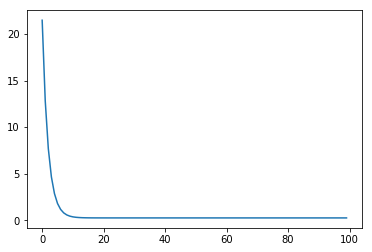

In [62]:
#lossの変化をプロット
plt.plot(losses)

In [63]:
#最終的に推定されたwの値は以下の通り
w

tensor([1.0078, 2.0618, 3.0018], requires_grad=True)

### torch.optimの利用

In [80]:
net.parameters()

<generator object Module.parameters at 0x11a23c5c8>

In [85]:
#Linear層を作成。今回は切片項は回帰係数に含めるので、入力の次元を3とし、bias(切片）をFalseにする
net = nn.Linear(in_features=3,out_features=1,bias=False)
#SGDのオブティマイザーに上で定義したネットワークのパラメータを渡して初期化
optimizer = optim.SGD(net.parameters(),lr=0.1)
#MSELossクラス
loss_fn = nn.MSELoss()

In [86]:
#損失関数のログ
losses = []

#100回イテレーションを回す
for epoc in range(100):
    #前回のbackwardメソッドで計算された勾配の値を削除
    optimizer.zero_grad()
    
    #線型モデルでyの予測値を計算
    y_pred = net(X)
    
    #MSE_lossを計算
    #y_predは(n,1)のようなshapeを持っているので(n,)に直す必要がある
    loss = loss_fn(y_pred.view_as(y), y)
    
    #lossのwによる微分を計算
    loss.backward()
    
    #勾配を更新する
    optimizer.step()
    
    #収束確認のためにlossを記録
    losses.append(loss.item())

In [87]:
losses

[13.152225494384766,
 7.9776082038879395,
 4.887302875518799,
 3.039928913116455,
 1.9343810081481934,
 1.2719944715499878,
 0.8746193647384644,
 0.6358981728553772,
 0.4922723174095154,
 0.40572088956832886,
 0.35347306728363037,
 0.3218744695186615,
 0.30272626876831055,
 0.2910984754562378,
 0.28402167558670044,
 0.27970457077026367,
 0.2770645022392273,
 0.2754458487033844,
 0.27445077896118164,
 0.2738374173641205,
 0.2734582722187042,
 0.2732231914997101,
 0.2730770409107208,
 0.27298590540885925,
 0.2729288637638092,
 0.27289310097694397,
 0.27287057042121887,
 0.27285635471343994,
 0.27284741401672363,
 0.2728416621685028,
 0.2728380858898163,
 0.27283579111099243,
 0.27283427119255066,
 0.27283337712287903,
 0.2728327214717865,
 0.27283230423927307,
 0.27283206582069397,
 0.27283191680908203,
 0.2728317975997925,
 0.2728317677974701,
 0.27283167839050293,
 0.27283164858818054,
 0.27283161878585815,
 0.27283164858818054,
 0.27283158898353577,
 0.27283161878585815,
 0.2728315889

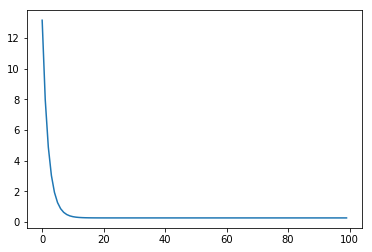

In [89]:
plt.plot(losses)

## ロジスティック回帰モデル 

In [112]:
#今回用いるirisデータセットのロードと中身の確認
from sklearn.datasets import load_iris
iris = load_iris()
for i in iris:
    print(i,"======================\n",iris[i])

#irisデータセットは0,1,2の3クラスなので、今回は0,1の2クラスのデータのみを利用
X = iris.data[0:100]
y = iris.target[0:100]
#numpyのndarrayをpytorchのtensorに変換
X = torch.tensor(X, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32)

data ======================
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [

In [122]:
#モデルの構築
net = nn.Linear(4, 1)

#シグモイド関数を作用させ、2クラス分類のクロスエントロピーを計算する関数
loss_fn = nn.BCEWithLogitsLoss()
#SGD
optimizer = optim.SGD(net.parameters(), lr = 0.25)

In [127]:
#損失関数のログ
losses = []

#100回イテレーションを回す
for epoc in range(100):
    optimizer.zero_grad()
    y_pred = net(X)
    loss = loss_fn(y_pred.view_as(y),y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

In [129]:
losses

[0.8496102690696716,
 1.0882059335708618,
 0.633676290512085,
 0.7638390064239502,
 0.4604349434375763,
 0.46952176094055176,
 0.2858083248138428,
 0.24176645278930664,
 0.17795133590698242,
 0.15804241597652435,
 0.1459852010011673,
 0.13827574253082275,
 0.13174651563167572,
 0.12586820125579834,
 0.1204976737499237,
 0.11556778103113174,
 0.11102678626775742,
 0.10683099925518036,
 0.10294288396835327,
 0.0993301272392273,
 0.09596476703882217,
 0.09282242506742477,
 0.08988180011510849,
 0.08712423592805862,
 0.0845332071185112,
 0.08209418505430222,
 0.07979424297809601,
 0.07762183248996735,
 0.07556672394275665,
 0.07361966371536255,
 0.07177237421274185,
 0.07001738995313644,
 0.0683479905128479,
 0.06675806641578674,
 0.06524209678173065,
 0.06379503011703491,
 0.06241227313876152,
 0.06108963117003441,
 0.059823278337717056,
 0.058609675616025925,
 0.05744563043117523,
 0.05632810667157173,
 0.055254414677619934,
 0.05422200262546539,
 0.05322851985692978,
 0.0522718206048011

In [128]:
y_pred

tensor([[-4.0485],
        [-3.1554],
        [-3.6573],
        [-3.0345],
        [-4.1921],
        [-3.9827],
        [-3.6692],
        [-3.6403],
        [-2.8618],
        [-3.1951],
        [-4.2461],
        [-3.3757],
        [-3.2161],
        [-3.7350],
        [-5.4957],
        [-5.3300],
        [-4.8411],
        [-3.9628],
        [-3.9748],
        [-4.2541],
        [-3.3110],
        [-3.9997],
        [-4.9506],
        [-2.8103],
        [-2.7319],
        [-2.7512],
        [-3.2543],
        [-3.8589],
        [-3.9049],
        [-3.0135],
        [-2.8698],
        [-3.5688],
        [-4.9564],
        [-5.3288],
        [-3.1094],
        [-3.9468],
        [-4.3630],
        [-4.2529],
        [-3.2451],
        [-3.6653],
        [-4.1524],
        [-2.0040],
        [-3.5823],
        [-3.2515],
        [-3.3100],
        [-3.0447],
        [-4.1252],
        [-3.4177],
        [-4.2211],
        [-3.6863],
        [ 4.0929],
        [ 3.8993],
        [ 4.

## 深層学習モデル定義

### モデル

#### 記法1
kerasなどと同様の書き方ができます<br>
各層に名前をつける事ができます(下の例だと'fc1','relu','fc2')

In [44]:
model = nn.Sequential()
model.add_module('fc1', nn.Linear(10,100))
model.add_module('relu', nn.ReLU())
model.add_module('fc2', nn.Linear(100,10))

#### 記法2
層をリストにまとめてモデルに挿入することもできます。

In [45]:
layer = []
layer.append(nn.Linear(10,100))
layer.append(nn.ReLU())
layer.append(nn.Linear(100,10))
model = nn.Sequential(*layer)

#### 記法3
クラスとして定義することも可能です<br>
以下、主にこの記法に基づいて説明します.

In [235]:
import torch.nn.functional as F
class Model(nn.Module):
    def __init__(self):
        #層を表す変数について定義
        super(Model,self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self,x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self,x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = Model()
model

Model(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [202]:
params = list(model.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


In [204]:
input_model = torch.randn(1, 1, 32, 32)
out = model(input_model)
print(out)

tensor([[ 0.1135, -0.2168, -0.0346,  0.0507, -0.0894, -0.0497,  0.1061,  0.0091,
         -0.0920,  0.0105]], grad_fn=<AddmmBackward>)


#### リスト記法の注意点
レイヤーをリストで保持した際は、同じハイパーパラメータのレイヤーを何度も使う際にはfor文を使って定義すれば楽なのですが，<br>
学習可能なパラメータをリストで保持してしまうと，<br>
モデルのパラメータを呼び出すときにリストで保持しているレイヤーのパラメータはパラメータとして認識されず呼び出されません．<br>
そうすると何が起こるかというと，学習の時にパラメータの更新が行われなくってしまいます．<br>
以下悪い例です．

In [231]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer = [nn.Linear(10,10) for _ in range(10)]
        #ここでレイヤーをリストで表現.

    def forward(self, x):
        for i in range(len(self.layer)):
            x = self.layer[i](x)
        return x

model = Model()
# model.parameters()で学習パラメータのイテレータを取得できるが，
# listで保持しているとlist内のモジュールのパラメータは取得できない
# optimについては後述
optimize = optim.SGD(model.parameters(), lr=0.1)

ValueError: optimizer got an empty parameter list

そのためこのような場合にはnn.ModuleListを使って定義します．

In [233]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        layer = [nn.Linear(10,10) for _ in range(10)]
        self.layer = nn.ModuleList(layer)

    def forward(self, x):
        for i in range(len(self.layer)):
            x = self.layer[i](x)
        return x

model = Model()
# model.parameters()で学習パラメータのイテレータを取得できるが，
# listで保持しているとlist内のモジュールのパラメータは取得できない
# optimについては後述
optimize = optim.SGD(model.parameters(), lr=0.1)

In [236]:
model

Model(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [237]:
#勾配を初期化
model.zero_grad()

#ランダムな勾配でback-propagation
out.backward(torch.randn(1, 10))

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

### fine tuning
pytorchではtorchvision.modelsを使うことで<br>
AlexNet、VGGNet、ResNet、DenseNet、SqueezeNet、GoogleNetが簡単に定義可能で、<br>
また、これらの学習済みモデルを簡単に使用することができます。

In [94]:
import torchvision.models as models
resnet = models.resnet50(pretrained=True) #PretrainedオプションをTrueにすることで学習済みモデルをダウンロード可能
resnet.fc = nn.Linear(2048, 100) #このように、層の名前を指定して出力を変更できます
resnet2 = nn.Sequential(*list(resnet.children())[:-3])#また、一部の層のみを使いたい場合はこののように記述できます
#重みの学習をしたくない場合は以下のように各パラメータのrequire_gradをFalseにすることで重みを固定することができます
for param in resnet.parameters():
    param.requires_grad = False

## 学習
optimパッケージを使って任意の最適化手法を用いてパラメータの更新を行います。<br>
最適化手法のパラメータを設定したら、backward計算をするたびstep()を呼び出すことで更新を行うことができます。

### 損失関数

In [225]:
#input->net->output
output = model(input_model)

#ラベル情報
target = torch.range(1, 10)  # a dummy target, for example

#loss関数の定義
criterion = nn.MSELoss()

#どの部分でlossの比較をするか
loss = criterion(output, target)
print(loss)

tensor(38.6841, grad_fn=<MseLossBackward>)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  """


### Backpropagation

In [238]:
#勾配を初期化
model.zero_grad()     # zeroes the gradient buffers of all parameters

#back propagation前
print('conv1.bias.grad before backward')
print(model.conv1.bias.grad) #conv1層のbiasの勾配

#lossに基づくback propagation
loss.backward()

#back propagation後
print('conv1.bias.grad after backward')
print(model.conv1.bias.grad)

conv1.bias.grad before backward
None


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [99]:
#Pytorch 0.4 以降
if torch.cuda.is_available(): # GPUが利用可能か確認
    device = 'cuda'
else:
    device = 'cpu'
# modelの定義
model = models.resnet18()
model = model.to(device)
# 最適化手法のパラメータ設定
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# loss関数の定義
criterion = nn.MSELoss()
# 入力と正解を乱数で生成
input = torch.randn(1,3,224,224) # バッチ x チャネル x 高さ x 幅
target = torch.randn(1,1000)
target.requires_grad = False
# バッチ正規化等、学習時と推論時で振る舞いの違うモジュールの振る舞いを学習時の振る舞いに
# model.eval()で推論時の振る舞いに変更可能
model.train()
# 学習ループ
for i in range(100):
  # 順伝播
  out = model(input)
  # ロスの計算
  loss = criterion(out, target)
  # 勾配の初期化
  optimizer.zero_grad()
  # 勾配の計算
  loss.backward()
  # パラメータの更新
  optimizer.step()

In [110]:
#Loss関数の指定
criterion = nn.CrossEntropyLoss()

#Optimizerの指定
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [239]:
#トレーニング
#エポック数の指定
for epoch in range(2):  # loop over the dataset multiple times
    #データ全てのトータルロス
    running_loss = 0.0 
    for i, data in enumerate(trainloader):

        #入力データ・ラベルに分割
        # get the inputs
        inputs, labels = data

        # Variableに変形
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # optimizerの初期化
        # zero the parameter gradients
        optimizer.zero_grad()

        #一連の流れ
        # forward + backward + optimize
        outputs = net(inputs)

        #ここでラベルデータに対するCross-Entropyがとられる
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # ロスの表示
        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

NameError: name 'trainloader' is not defined

## モデルの保存と読み込み

In [150]:
#モデルの保存
torch.save(model.state_dict(), 'model.pth')
#モデルの読み込み
param = torch.load('model.pth')
model = Model() #読み込む前にクラス宣言が必要
#model = Net()
model.load_state_dict(param)

## カスタマイズ
### 自作活性化関数

In [113]:
class MyReLU(torch.autograd.Function):

    #forwardの活性化関数とbackwardの計算のみ記述すれば良い
    def forward(self, input):

        #値の記憶
        self.save_for_backward(input)

        #ReLUの定義部分
        #x.clamp(min=0) <=> max(x, 0)
        return input.clamp(min=0)

    #backpropagationの記述
    #勾配情報を返せば良い
    def backward(self, grad_output):

        #記憶したTensorの呼び出し
        input, = self.saved_tensors

        #参照渡しにならないようコピー
        grad_input = grad_output.clone()

        #input<0 => 0  else input
        grad_input[input < 0] = 0
        return grad_input

### 自作ロス関数

In [115]:
class TripletMarginLoss(nn.Module):
    def __init__(self, margin):
        super(TripletMarginLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        dist = torch.sum(
            torch.pow((anchor - positive),2) - torch.pow((anchor - negative),2),
            dim=1) + self.margin
        dist_hinge = torch.clamp(dist, min=0.0)  #max(dist, 0.0)と等価
        loss = torch.mean(dist_hinge)
        return loss

## ダイナミックネットワーク
defined-by-run形式なので、forward部分に条件分岐などしてレイヤーを組み替えることもできる


In [116]:
class DynamicNet(torch.nn.Module):

    #層の定義
    def __init__(self, D_in, H, D_out):
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)

    #ランダムに中間層を0~3に変更する
    def forward(self, x):
        h_relu = self.input_linear(x).clamp(min=0)
        for _ in range(random.randint(0, 3)):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
        y_pred = self.output_linear(h_relu)
        return y_pred

In [117]:
x = Variable(torch.ones(2, 2), requires_grad = True)

In [122]:
x = torch.ones(2, 2, requires_grad = True)
x.data
x.grad
y = x + 2
z = y * y * 3
out = z.mean()
out.backward()

In [128]:
y.data

tensor([[3., 3.],
        [3., 3.]])

In [130]:
y.grad

None


### GAN

In [159]:
mnist.data[0].size()

torch.Size([28, 28])

In [168]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'samples'

# Image processing
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5),   # 3 for RGB channels
                                                     std=(0.5))])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../../data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# Device setting
D = D.to(device)
G = G.to(device)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    
# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

IndexError: too many indices for tensor of dimension 0

### RNN (LSTM)

In [169]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/2], Step [100/600], Loss: 0.5952
Epoch [1/2], Step [200/600], Loss: 0.2299
Epoch [1/2], Step [300/600], Loss: 0.1024
Epoch [1/2], Step [400/600], Loss: 0.2094
Epoch [1/2], Step [500/600], Loss: 0.1041
Epoch [1/2], Step [600/600], Loss: 0.0315
Epoch [2/2], Step [100/600], Loss: 0.1303
Epoch [2/2], Step [200/600], Loss: 0.0844
Epoch [2/2], Step [300/600], Loss: 0.0899
Epoch [2/2], Step [400/600], Loss: 0.0348
Epoch [2/2], Step [500/600], Loss: 0.0740
Epoch [2/2], Step [600/600], Loss: 0.2158
Test Accuracy of the model on the 10000 test images: 97.37 %
